# Starbucks Capstone Challenge: Using Starbucks App User Data to predict effective offers

## Introduction

This data set contained simulated data that mimiced customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sent out an offer to users of the mobile app. An offer could be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users received the same offer, and that was the challenge to solve with this data set.

My task was to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set was a simplified version of the real Starbucks app because the underlying simulator only had one product whereas Starbucks actually sells dozens of products.

Every offer had a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. I would see in the data set that informational offers had a validity period even though these ads were merely providing information about a product; for example, if an informational offer had 7 days of validity, I could assume the customer was feeling the influence of the offer for 7 days after receiving the advertisement.

I would be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also had a record for each offer that a user received as well as a record for when a user actually viewed the offer. There were also records for when a user completed an offer. 

Kept in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

**Note:** If I was using the workspace, I would need to go to the terminal and run the command `conda update pandas` before reading in the files. This was because the version of pandas in the workspace could not read in the transcript.json file correctly, but the newest version of pandas could. I could access the terminal from the orange icon in the top left of this notebook.  

I could see how to access the terminal and how the installation worked using the two images below. First I needed to access the terminal:

<img src="pic1.png"/>

Then I would want to run the above command:

<img src="pic2.png"/>

Finally, when I entered back into the notebook (using the jupyter icon again), I should be able to run the below cell without any errors.

## Project Overview

In my capstone project, I aimed to answer two main questions:

- What were the main drivers of an effective offer on the Starbucks app?

- Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?

This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contained simulated data that mimics customer behavior on the Starbucks rewards mobile app.

The provided background information on the mobile app was that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offer during certain weeks, and not all users receive the same offer.

## Problem Statement

As stated above, the problems I aimed to answer was to:

- discover the main drivers of offer effectiveness, and
- explore if we could predict whether a user would take up an offer.

The data provided consists of three datasets:

- Offer portfolio, which consisted of the attributes of each offer
- Demographic data for each customer
- Transactional records of events occurring on the app

Using the data provided, I answered the above two questions using three classification supervised machine learning models, feeding in the data from three different offer types.

I used the model to uncover the feature importances to identify the drivers of offer effectiveness, while exploring if the model itself could be used to predict if a user would take up an offer.

Lastly, I also explored the characteristics of users who do or do not take up an offer.

My project aimed to answer the two questions above, but I also ended up adding two additional models as points of exploration - the first assessing whether an all-in-one model could be used in place of three different models, with the offer types functioning as a categorical variable. Secondly, I also build a regression model to see if we could predict the amount a user would spend, given that the offer is effectively influencing them.

## Imported libraries & loaded data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# read in the json files

portfolio = pd.read_json('data/portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('data/profile.json', orient = 'records', lines = True)
transcript = pd.read_json('data/transcript.json', orient = 'records', lines = True)

## Data Exploration

### a. Offer portfolio data

According to the information provided by Udacity, the schema was as follows:

**portfolio.json**

* id (string) - offer id
* offer_type (string) - type of offer i.e. BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

Moreover, some further information given about the offers was that there are three different offer types:

- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Thus, the schema is pretty straightforward, as it contained the attributes of three different offer types. While the duration was not explained I assumed from context that it is in terms of number of days.

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


The channels column consisted of nested lists. Hence, I noted that I would have to expand the column later during preprocessing to become categorical variables in my dataset. I also noted that the scale of each variable was different, for example the difficulty was in terms of dollars while the duration was in terms of days. Hence, some feature scaling would need to be done.

In [3]:
# Checked for null values

portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

Good news was that there were no missing values in this dataset, hence I did not have to impute or make any decisions to remove them during the preprocessing stage.

In [4]:
# Checked no. of unique offers

portfolio.id.nunique()

10

In [5]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

There were ten unique offer ids we would have to take note of, with four each of bogo and discount types, while two were of informational types.

### b. Demographic data

Demographic data for customers was provided in the profile dataset. The schema and variables were as follows:

**profile.json**

* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (noted some entries contained 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

It was also relatively straightforward, as it contained the demographic profile of the customer.

In [6]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


From the first five records I could already see some null values in gender and income, while the age column contained some values that did not make sense (for e.g. 118).

In [7]:
# Checked for null values

profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

As suspected, the gender and income columns had null values. Some good news was that whichever values were null in gender were also null in income.

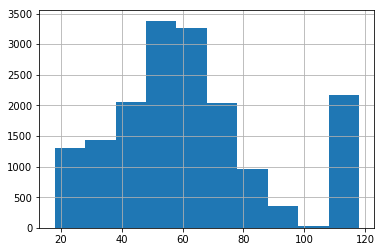

In [8]:
# Checked distribution of age column

profile.age.hist()

I could see above that the age = 118 value did not make sense there as it was clearly out of the normal distribution.

In [9]:
# Checked count of age = 118 value and corresponding gender and income columns

print(profile[profile['age'] == 118].count())
profile[['gender','income','age']][profile['age'] == 118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


As I could see above, the age = 118 column corresponds with the null gender and income columns. Thus, I could actually drop them during preprocessing if they did not take too large a proportion of our data.

In [10]:
# Checked how many unique people were in dataset

profile['id'].nunique()

17000

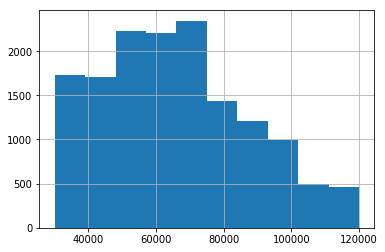

In [11]:
# Checked distributions of income

profile.income.hist()

Last but not least, the became_member_on column had some potential to be feature engineered to get the tenure of membership in days. This feature might have some influence on whether an offer was effective or not.

In [12]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

### c. Transactional records

The schema for the transactional data was as follows:

**transcript.json**

* event (str) - record description (i.e. transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data began at time t = 0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [13]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [14]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

This data looked a bit trickier, as it was ordered by time and had an event and value. In particular, the value column would have to be preprocessed depending on the event.

In [15]:
# Checked number of unique people represented

transcript['person'].nunique()

17000

It looked as though the number of people in transcript were the same as the number of people in the Demographics Data, so that was good news. But a lot of preprocessing would need to be done in order to extract meaningful insights out of this dataset.

In [16]:
# Checked for null values

transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

There were no null values in this data.

In order to extract insights from the value column, I would have to expand the values into individual columns depending on the event.

In [17]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


It appeared as though the offer id column ended up being duplicates so I had to clean it up further to ensure there was only one offer id column.

In [18]:
# Created new column to ensure only one offer_id column

transcript['offer_id_new'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

# Dropped unnecessary offer_id columns

transcript.drop(['offer id', 'offer_id'],axis = 1, inplace = True)

# Renamed offer_id column

transcript.rename(columns = {'offer_id_new' : 'offer_id'}, inplace = True)

In [19]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


The additional transcript columns could be used for further exploration.

## Defined approach for preprocessing data for the model

Before I proceeded to preprocess the data for the model, I first revisited my objective. Having done a preliminary exploration of the data, I had to reassess how I would clean and prepare the data for the models I intended to build.

In order to identify the main drivers of an effective offer, I had to first define what an 'effective' offer is within the Starbucks app. Thus, I did some further exploration on the datasets and how all three would interact.

First, I had to explore what kind of events were within each offer type.

In [20]:
# Renamed column

portfolio.rename(columns = {'id' : 'offer_id'}, inplace = True)

# joined transcript with offer type

transcript = transcript.merge(portfolio, how = 'left', on = 'offer_id')

In [21]:
transcript.groupby(['event', 'offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

I knew that there were four types of events: offer completed, offer received, offer viewed and transaction. But my data showed that I did not have any offer_id associated with transactions, because they were not recorded in the transcript event data. Thus, the first objective in data preprocessing is to define a methodology to assign offer_ids to specific transactions.

Moreover, I also knew that BOGO and discount offers had an offer completed event when offers were completed. However, informational offers did not have this event associated with it. Thus, I also specified the approach to define an effective offer as follows:

For a BOGO and discount offer, an effective offer would be defined if the following events were recorded in the right sequence in time:

offer received -> offer viewed -> transaction -> offer completed

Meanwhile, for an informational offer, since there was offer completed event associated with it, I would have to define transactions as a conversion to effective offer:

offer received -> offer viewed -> transaction

## Data Preprocessing

#### a. Assigned offer ids to transactions

After defining the approach above, I had to explore methods to assign offer_ids to specific transactions. Among the considerations was to define the following main groups of customers:

1. People who were influenced and successfully converted - effective offers:

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (BOGO/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

2. People who received and viewed an offer but did not successfully convert - ineffective offers:

- `offer received` -> `offer viewed`

3. People who purchased/completed offers regardless of awareness of any offers:

- `transaction`
- `offer received` -> `transaction` -> `offer completed` -> `offer viewed`
- `transaction` -> `offer received` -> `offer completed` -> `offer viewed`
- `offer received` -> `transaction` -> `offer viewed` -> `offer completed`
- `offer received` -> `transaction` (informational offers)
- `offer received` -> `transaction` -> `offer viewed` (informational offers)

4. People who received offers but no action taken:

- `offer received`

For people in group 2, I would need to check if there were events where there was an offer received and offer viewed event, but no conversion event, i.e. offer completed or transaction - these were cases of ineffective offers.

I would have to separate out the people in group 2 from people in group 4, as people in group 2 may have viewed an offer but did not take any action, whereas people in group 4 did not even have an offer viewed event.

Separating the conversions for effective offers (group 1) and people who purchased/completed offers regardless of awareness of any offers (group 3) is particularly tricky. For people in group 3, a conversion is invalid (i.e., not a successful conversion from an offer) if an offer completed or transaction occurs before an offer viewed. There also may be scenarios where an offer completed occurs after the offer is viewed, but a transaction was done prior to the offer being viewed. In this instance, the offer may have been completed, but it is also not a valid conversion.

#### Defined the target variable effective offer:

After defining these conditions, I had to decide what the target variable will be.

I knew that group 1 customers would be my target variable effective_offer = 1, but there were many ineffective offer definitions for groups 2-4.

So what would I define as an ineffective offer? As already stated above, group 2 would be within our definition of an ineffective offer; where a user was aware of an offer, but the offer was ineffective as it did not convert the user into a customer. So group 2 can be defined as our target variable effective_offer = 0.

What about group 3 and group 4? Group 3 consisted of users who may have received offers but would have purchased regardless. From the business point of view, I would not want to be sending them any offers.

Meanwhile, group 4 users would be considered low priority customers, as they do not do any action, regardless of whether they receive offers or not.

So, I could deprioritise group 3 and group 4 users from our model. It would still be worth doing some exploratory analysis onto group 3 and 4, just to explore on their demographics.

The conditions above were the basis of which I could assign the offer id that 'influences' a transaction by ensuring that the transaction occured after an offer viewed event.

After sorting the transcript dataset by person and time to ensure that each event for each person occured in sequence, I could filter the dataset by events offer viewed and transaction to ensure that it only contained those events in order.

Then, I could use pandas' ffill() method to fill every transaction with the offer_id of the viewed offer, only if it occured before the transaction.

In [22]:
# Defined dropcolumns function as I would be doing this many times

def drop_cols(drop_cols, df, inplace = False):
    '''
    
    inputs:
    
    - drop_cols: list or string of column name to be dropped
    - df: dataframe from which column should be dropped
    - inplace: specify whether columns are dropped in place or not
    
    outputs:
    
    - Returns dataframe with dropped columns.
       
    '''
    
    df = df.drop(columns = drop_cols, axis = 1, inplace = inplace)
    return df

In [23]:
# Dropped unnecessary columns to clean dataset

transcript = drop_cols(['reward_x', 'reward_y'], transcript)

# Sorted events by person and time

transcript = transcript.sort_values(['person', 'time'])

In [24]:
# Filtered dataset for transactions that occured after an offer was viewed, forward filled offer ids by person

offers_view_transacted = transcript[['time', 'offer_id', 'person', 'event']][(transcript['event'] == 'transaction') | (transcript['event'] == 'offer viewed')].groupby(['person', 'offer_id']).ffill()
offers_view_transacted['offer_id'] = offers_view_transacted['offer_id'].ffill()

Since the above temporary dataset was just a subset of the transcript dataset, I could create a new dataset with the filled in offer ids for transactions.

In [25]:
transcript=transcript.merge(offers_view_transacted, how = 'left', on = ['person', 'time', 'event'])

In [26]:
# Cleaned up dataset to unify multiple offer_id columns into one column

transcript['offer_id'] = np.where(transcript['offer_id_x'].isnull(), transcript['offer_id_y'], transcript['offer_id_x'])

drop_cols(['offer_id_x', 'offer_id_y'], transcript, inplace = True);

In [27]:
# Merged portfolio dataset again to get offer data for the transaction events

transcript = transcript.merge(portfolio, how = 'left', on = 'offer_id')
transcript['duration'] = np.where(transcript['duration_x'].isnull(), transcript['duration_y'], transcript['duration_x'])
drop_cols(['duration_x', 'offer_type_x', 'difficulty_x', 'channels_x', 'duration_y'], transcript, inplace = True);
transcript.rename(columns = {'channels_y' : 'channels', 'reward_y' : 'reward', 'difficulty_y' : 'difficulty', 'offer_type_y' : 'offer_type'}, inplace = True)

In [28]:
transcript.head()

,event,person,time,value,amount,offer_id,channels,difficulty,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,informational,0,4.0


#### b. Flagged transactions and offers completed after offers viewed

The next important step for preparing my data for modeling and analysis was to identify a completed offer and transactions that occurred after an offer was viewed.

Once I had assigned a transaction that occurred after an offer was viewed, I could use that information to subset my data according to the groups defined above, and analyse within each group.

Using my dataset with the offer_ids populated for transaction events, I could flag the converted transactions and completed offers. I had to first ensure that the offer id of the previous event was the same one. Since I had tagged the offer id for all viewed, transactions and completed offers, I could use the offer_id field to ensure that the previous offer consisted of those events.

This meant that as long as the events offer viewed, transaction, and offer completed occured in the same event space and were in the corrrect sequence of time, I could be assured that it was a transaction and/or completed offer occurring only after an offer was viewed.

To do this, I created a new column to flag the previous offer id using pandas' shift function.

In [29]:
# Got sample space of events consisting of offer viewed, transactions and offer completed

offers_viewed_transactions_completed = transcript[(transcript['event'] == 'offer viewed') | (transcript['event'] == 'transaction') | (transcript['event'] == 'offer completed')].copy()

In [30]:
# Added extra column to flag the previous offer id

offers_viewed_transactions_completed['offer_id_previous'] = offers_viewed_transactions_completed.groupby(['person', 'offer_id'])['offer_id'].shift()

In [31]:
# Flagged a completed transaction/offer completed as long as the previous offer id consists of events in the same sample space

offers_viewed_transactions_completed['valid_completed'] = np.where(offers_viewed_transactions_completed['offer_id_previous'] == offers_viewed_transactions_completed['offer_id'], 1, 0)

Since my dataset offers_viewed_transactions_completed consisted of all other possible events, all I needed to do was to append the all offers received events in the transactions_clean dataset to ensure I had my complete dataset again.

In [32]:
# Got only offer received events

offers_received = transcript[transcript['event'] == 'offer received'].copy()

# Ensured all columns were the same between datasets to be appended

offers_received['offer_id_previous'] = np.nan
offers_received['valid_completed'] = np.nan

# Appended datasets to complete dataset of transactions

transcript = offers_received.append(offers_viewed_transactions_completed)

# Sorted values

transcript = transcript.sort_values(['person', 'time'])

Having assigned offer_ids for transactions for which an offer viewed event occurred prior, I could now revisit the four customer groups of unique person-offer_id pairs I was trying to analyse.

Since I considered the conversion events of depending on offer type differently, I had to first separate the transcript into three different offer types, in order to accommodate for the different treatment in assigning the target variable.

In [33]:
# Defined function to split into three offer types

def split(offer_type, grp_df):
    '''
    Splits dataframe to groups of specified offer type.
    
    inputs:
    
    - offer_type: specify offer type name in string format 
    - grp_df: original transcript dataframe to split on offer type
    
    outputs:
    - Returns dataframe containing data of just offer type.
       
    '''
    
    df = grp_df[grp_df['offer_type'] == offer_type].copy()
    return df

# Splitted transcript into three different offer types

transcript_bogo = split('bogo', transcript)
transcript_discount = split('discount', transcript)
transcript_info = split('informational', transcript)

Within each offer type, I could already successfully separate every unique person-offer_id in group 1 from the others using our valid_completed column. Since I had flagged all conversion events (transaction or offer completed event depending on offer type) occurring after an offer viewed event, I could be assured that whichever conversion events were flagged with valid_completed = 1 were at least within the first group (People who were influenced and successfully converted - effective offers).

For BOGO and discount offers, I would only consider offer completed events as the conversion events, while I could consider transaction event as the conversion event for the informational offers.

In [34]:
# Since I would do this for both BOGO and discount I defined a function for repeated operation

def grp1(df):
    '''
    Subsets dataframe to just group 1 members.
    
    inputs:
    
    - df: original transcript dataframe 

    outputs:
    
    - Returns dataframe containing transcript data of just group 1 users.
       
    '''
    
    grp1 = df[['person', 'offer_id']][(df['valid_completed'] == 1) & (df['event'] == 'offer completed')].groupby(['person', 'offer_id']).count().reset_index()
    return grp1

grp1_bogo = grp1(transcript_bogo)
grp1_discount = grp1(transcript_discount)

Meanwhile, for informational offers I would define group 1 later as there was an additional consideration I needed to take into account for transactions - they needed to occur within the validity period of an informational offer for me to consider them as effective offers.

I could now look into separating group 2 and group 4 unique person-offer_ids for BOGO and discount offers as I just needed to look at the subset of people with offer received, offer viewed, but no conversion events. I could also assume that every person who viewed an offer would have had an offer received event prior, so I could just take the whole group of people who received an offer and subset them later.

In [35]:
# Again, I defined a function as I would repeat this for 2 datasets - BOGO & discount

def no_conv(df):
    
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
    
    Note: left_only indicator is just the offers received events, right_only is just conversion events
       
    '''
    
    # Subset offer ids that had transactions or conversions by person and offer_id
    
    conversion_ids = df[['person', 'offer_id']][(df['event'] == 'transaction') | (df['event'] == 'offer completed') ].groupby(['person', 'offer_id']).count().reset_index()

    # Checked for unique person-offer_id pairs that consisted of offers received 
    
    offers_received_only = df[['person', 'offer_id']][df['event'] == 'offer received'].groupby(['person','offer_id']).count().reset_index()

    # Created merged dataset to diffrentiate groups
    
    check_merge = conversion_ids.merge(offers_received_only, how = 'right', on = ['person', 'offer_id'], indicator = True)
    return check_merge

# Checked how many were in either group

check_merge_bogo = no_conv(transcript_bogo)
print('For BOGO offers:')
print(check_merge_bogo.groupby(['_merge']).count())

check_merge_discount = no_conv(transcript_discount)
print('For Discount offers:')
print(check_merge_discount.groupby(['_merge']).count())

For BOGO offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    4729      4729
both         20592     20592
For Discount offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    6415      6415
both         18901     18901


I could see that there were definitely a fair number of unique person-offer_id pairs that have offer received events, but no conversion events. These would be considered offers in group 2 and 4 within each offer type, according to my definition above.

People with an offer viewed event in this subset were definitely in group 2, as I could assume everyone with an offer viewed event had an offer received event prior.

In [36]:
# Defined group 2 & 4 function as I would repeat this for BOGO and discount offers

def grp_2_4(df):
    
    '''
    Takes in output dataframe from no_conv function to split into group 2 and 4 customers.
    
    inputs:
    
    - df: output dataframe from no_conv function
    
    outputs:
    
    - Returns 2 dataframes containing unique person-offer_id pairs with dataframe containing only group2 customers first, followed by dataframe containing only group 4 customers. 
       
    '''
    
    # Subset to check group 2 and 4
    
    grp_2_4 = df[df['_merge'] == 'right_only']

    # Remerged with transcript to get events
    
    grp_2_4 = grp_2_4.merge(transcript, how = 'left', on = ['person','offer_id'])

    # Within this subset, separated people with offer viewed event, and people with offer received but no offer viewed
    
    grp2 = grp_2_4[['person', 'offer_id']][grp_2_4['event'] == 'offer viewed'].groupby(['person', 'offer_id']).count().reset_index()
    
    # Remerged with full dataset and got remaining to get grp4
    
    drop_cols('_merge', grp_2_4, inplace = True)
    grp4 = grp_2_4.merge(grp2[['person', 'offer_id']], how = 'left', indicator = True)
    grp4 = grp4[grp4['_merge'] == 'left_only'].copy()
    
    return grp2,grp4

grp2_bogo, grp4_bogo = grp_2_4(check_merge_bogo)
grp2_discount, grp4_discount = grp_2_4(check_merge_discount)

Group 3 people were everyone in the converted ids who did not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For BOGO and discount offers, they would be people with offer completed events that have valid_completed != 1.

In [37]:
def grp3(df):
    '''
    Takes in transcript dataframe of single offer type to check for people who converted vs people with just offer received events. 
    
    inputs:
    
    - df: original transcript dataframe of specific offer type 
    
    outputs:
    
    - Returns dataframe containing unqiue person-offer_id pairs with conversion events and offers received events, with indicator of each.
       
    '''
    
    # Checked all conversion events with invalid conversions
    
    grp3 = df[['person', 'offer_id']][(df['event'] == 'offer completed') & (df['valid_completed'] != 1)].groupby(['person', 'offer_id']).count().reset_index()
    return grp3

grp3_bogo = grp3(transcript_bogo)
grp3_discount = grp3(transcript_discount)

I had split my data into four different customer groups for the BOGO and discount offers. Next, I had to consider the effective and ineffective offers depending on the group type. As already elaborated above, any unique person-offer_id belonging to group 1 could be considered in my target variable effective_offer = 1 group.

Meanwhile, group 2 was in my target variable effective_offer = 0 group. For customers in groups 3 and 4, I deprioritised them for model implementation, but would be doing some exploratory analysis on them later.

In [38]:
def offers(grp1,grp2):
    '''
    inputs:
    
    - grp1: dataframe containing group1 customer data 
    - grp2: dataframe containing group2 customer data
    
    outputs:
    
    - Returns dataframe with labeled effective offer column
    '''
    
    # Assigned effective offer flag column
    
    grp1['effective_offer'] = 1
    grp2['effective_offer'] = 0

    # Appended datasets together
    
    offers = grp1.append(grp2, sort = False)
    return offers

offers_bogo = offers(grp1_bogo, grp2_bogo)
offers_discount = offers(grp1_discount, grp2_discount)

I had successfully prepared the target variables for my BOGO and discount datasets.

Meanwhile, for informational offers in particular, before I could tag the effective offers column, there was one more consideration - the validity of the offer.

#### c. Considered duration/validity of offers in converted transactions from informational offers

There was an additional rule to consider when considering an effective/converted transaction and offer. This applied for offers that were of type 'informational'. As already elaborated above, the reason why informational offers got a different treatment was because the conversion event was not an offer completed event, but a transaction.

For informational offers, the duration of the offer could be considered to be the duration of the influence. Hence, I could make the assumption that an offer should only be considered effective if it was within the duration of the offer.

Meanwhile, for BOGO and discount offers, I could assume that if there was a conversion/ offer completed event, it should be within duration as it would not make sense for an offer to be completed if an offer was past its' validity period.

I saw in my data dictionary, the time of an event in the transcript data was in terms of hours. In order to ensure it was on the same scale as the duration of the offer, I had to convert it into days.

In [39]:
# Converted time into days

transcript_info['day_offer'] = transcript_info['time'] / 24

# Dropped unnecessary columns

drop_cols(['time', 'value', 'offer_id_previous'], transcript_info, inplace = True);

In [40]:
# Sorted transactions to ensure all events occurred by person and offer

transcript_info = transcript_info.sort_values(['person', 'day_offer', 'event', 'offer_id'])

I could get the difference between two events using the diff function in pandas. I took the difference between the transaction and the offer received as the duration.

In [41]:
# Got difference in time for informational offers

transcript_info['diff_info'] = transcript_info[(transcript_info['offer_type'] == 'informational') & ((transcript_info['event'] == 'offer received') | (transcript_info['event'] == 'transaction'))].groupby(['person', 'offer_id'])['day_offer'].diff()

In [42]:
# Created column for flagging valid events

transcript_info['valid_completed_duration'] = np.nan

# Flagged valid events if within duration

transcript_info.loc[transcript_info['diff_info'] <= transcript_info['duration'], 'valid_completed_duration'] = 1

# Filled any missing values with 0 flag

transcript_info['valid_completed_duration'] = transcript_info['valid_completed_duration'].fillna(value = 0)

With the valid_completed and valid_completed_duration flag columns, I had four possible scenarios for an informational offer within the transcript_info dataset:

| No. | valid_completed | valid_completed_duration | Scenario |
|-----|-----------------|--------------------------|----------|
|  1  |       1	        |            0	           | completed transaction after offer viewed event, but not within duration |
|  2  |     0/null      |	         1             | completed transaction within duration, but with no offer viewed event prior  |
|  3  |       1         |	         1             | completed transaction within duration, with offer viewed event - an effective offer |
|  4  |    0//null      |	         0             | did not complete transaction within duration, no offer viewed event prior |

Following the above scenarios, only Scenario 3 would be considered my label effective_offers = 1 for informational offers (group 1 of customers).

Meanwhile, Scenarios 1 and 2 could be considered to be actions that would put the customer into my Group 3 of customers - People who purchased/completed offers regardless of awareness of any offers.

For customers in Scenario 1, even though according to my valid_completed flag, they had viewed an offer prior to the transaction, but it was not within the duration, thus they were not 'influenced' by the offer.

Meanwhile for customers in Scenario 2, they were in Group 3 as they completed transactions without viewing an offer.

Scenario 4 can be considered in group 4, as they only consist of transactions.

I would need to separate those users in group 2 - those who may have received and viewed an offer, but no transactions after. I needed to subset those where effective_offer != 1 into groups 2, 3 and 4.

In [43]:
# Flaged effective_offers where valid_completed = 1 and valid_completed_duration = 1

transcript_info['effective_offer'] = np.where(((transcript_info['valid_completed'] == 1) & (transcript_info['valid_completed_duration']==1)),1,0)

I had flagged my effective offers, I could subset them into the 4 groups already outlined above. I could also filter this only for the effective offers = 1 events, as I only wanted the effective transactions influenced by an offer, not other transactions.

In [44]:
# Separated group 1 in transcript_into

grp1_info = transcript_info[['person', 'offer_id']][transcript_info['effective_offer'] == 1].groupby(['person', 'offer_id']).sum().reset_index()

From the remaining people, I had to separate it out into groups 2 and 4. I could use similar steps to what I did with BOGO and Discount offers, since I didn't have the duration consideration.

In [45]:
# Separated out group 2 of customers

check_merge_info = no_conv(transcript_info)
print('For informational offers:')
print(check_merge_info.groupby(['_merge']).count())

For informational offers:
            person  offer_id
_merge                      
left_only        0         0
right_only    5412      5412
both          7239      7239


In [46]:
grp2_info, grp4_info = grp_2_4(check_merge_info)

For group 3, I had to consider those with conversions who did not have an offer viewed prior - hence, they would be people with conversion events but no offer viewed event prior. For informational offers, these would be transactions in Scenario 1 and 2 above.

In [47]:
# Scenario 1

grp3_1 = transcript_info[['person', 'offer_id']][(transcript_info['event'] == 'transaction') & (transcript_info['valid_completed'] != 1) & (transcript_info['valid_completed_duration'] == 1)].groupby(['person', 'offer_id']).count().reset_index()

# Scenario 2

grp3_2 = transcript_info[['person', 'offer_id']][(transcript_info['event'] == 'transaction') & (transcript_info['valid_completed'] == 1) & (transcript_info['valid_completed_duration'] != 1)].groupby(['person', 'offer_id']).count().reset_index()
grp3_info = grp3_1.append(grp3_2, sort = False)
del grp3_1
del grp3_2

I could append the datasets together to make the offers_info dataset, ready for modeling.

In [48]:
offers_info = offers(grp1_info, grp2_info)

I had subset all my datasets into effective and ineffective offers depending on offer type, I could append the datasets accordingly into datasets for modeling.

#### d. Feature engineering

I had to look back into the features and see how to be creative in creating new features.

#### d. (i). became_member_on column to be engineered

Recalling my preliminary data exploration steps, the became_member_on column were in date format. Hence in order to extract meaningful insights from that feature, I could convert it as a feature indicating tenure of membership. There could be some influence in how long someone had been a member, with whether he took up an offer.

In [49]:
# Renamed column for merging

profile.rename(columns = {'id' : 'person'}, inplace = True)

# Created function to reuse for 3 datasets

def member(df):
    '''
    inputs:
    
    - df: original dataframe to transform became_member_on column  
    
    outputs:
    
    - Returns dataframe with became_member_on column transformed to be tenure in days
    
    '''
    
    # Merged to get user demographic profile
    
    df = df.merge(profile, how = 'left', on = 'person')
    
    # Converted became_member_on into member tenure
    
    df['year'] = pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month'] = pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day'] = pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = drop_cols('became_member_on',df)
    df.loc[df['year'] == 2018, 'membership_tenure_days'] = (30 * df['month']) + df['day']
    df.loc[df['year'] != 2018, 'membership_tenure_days'] = ((2018 - df['year']) * 365) + (30 * df['month']) + df['day']
    df = drop_cols(['year', 'month', 'day'], df)
    
    return df

offers_bogo = member(offers_bogo)
offers_discount = member(offers_discount)
offers_info = member(offers_info)

#### d. (ii). Count of offers received

As part of some further data exploration, I discovered that there could be multiple offers received per person.

person
0009655768c64bdeb2e877511632db8f    5
00116118485d4dfda04fdbaba9a87b5c    2
0011e0d4e6b944f998e987f904e8c1e5    5
0020c2b971eb4e9188eac86d93036a77    5
0020ccbbb6d84e358d3414a3ff76cffd    4
Name: event, dtype: int64


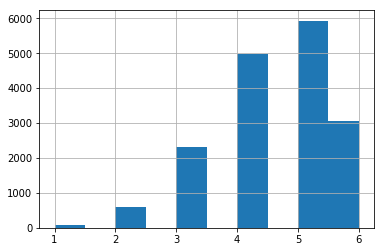

In [50]:
# Group event = offer received per person in transactional records

print(transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().head())

# Visualised offers received per person

transcript[transcript['event'] == 'offer received'].groupby('person')['event'].count().hist()

I could see above that the offer received per person in the transactional data could range from 1 to 6 offers received. I had the hypothesis that the frequency of offers received per person might result in more effective offers, so decided to engineer a feature offer_received_cnt to account for this frequency.

In [51]:
# Got count of offers received per person, put into separate dataset

df_offer_received_cnt = transcript[transcript['event'] == 'offer received'].groupby(['person', 'offer_id', 'time']).count()['event'].reset_index()

# Renamed columns

df_offer_received_cnt.rename(columns = {'event' : 'offer_received_cnt'}, inplace = True)

# Dropped unnecessary columns

drop_cols('time', df_offer_received_cnt, inplace = True)

# Ensured only unique person-offer_id pairs

df_offer_received_cnt = df_offer_received_cnt.groupby(['person', 'offer_id']).sum().reset_index()

#### d. (iii). Separated user behaviours by transactions

I also wondered how many transactions were considered 'invalid' by my definition. Ordinarily, these would be the sum of transactions done by people not in group 1. The objective of offers were to drive purchases, so it would already be the case that users with high spend in their transactions would be flagged as effective_offers.

I had already defined that there were people in groups 3 and 4, where they were separate pools of users who were loyal spenders, and already tend to purchase more, isolated from the the effect of offers.

But for users in group 1 had a high amount of 'invalid spend' outside of the effect of offers, there might be some predictive power onto the effectiveness of offers; since a loyal user might had a higher tendency of taking up an offer.

In my datasets, I had already separated the transactions who were conversions versus transactions who were just the users' normal purchasing behaviour. This was through the valid_completed column, where I checked if a transaction had an offer viewed event prior.

In the cases where valid_completed = 1, I had already included them in my effective offers flag for BOGO and Discount offers. However, for those transctions where valid_completed = 0, I had not considered them, and this could be a potential feature to include, as a proxy for the 'baseline' level of spending for a user.

The logic was to wonder if there was some baseline level of spending for users who are highly influenced by certain offers (in group 1), and group 2, and if there was some predictive power in this baseline level of 'invalid transactions' that could predict the propensity of a user to take up an offer.

In [52]:
# Filtered dataset by invalid transactions

df_transactions_invalid = transcript[(transcript['event'] == 'transaction') & (transcript['valid_completed'] == 0)].groupby(['person', 'offer_id'])['amount'].sum().reset_index()
df_transactions_invalid.rename(columns = {'amount' : 'amount_invalid'}, inplace = True)

#### d. (iv). Time elapsed between offers received

I also wanted to include time as a potential feature into my dataset, but since the transactional data starts from time = 0, I suspected it would not have been of much predictive power without some feature engineering. I had the hypothesis that if there were multiple offers received per person within a certain time period, there might be some predictive power in the time elapsed between offers received.

In [53]:
# Converted time into days

transcript['day_offer'] = transcript['time'] / 24

# Dropped unnecessary columns

drop_cols(['time'], transcript, inplace = True);

# Found time elapsed between offers received

transcript['time_elapsed_offers'] = transcript[transcript['event'] == 'offer received'].groupby(['person', 'offer_id'])['day_offer'].diff()

# Filled missing values with 0, as if someone did not receive an offer or was receiving an offer for the first time, there was no time elapsed

transcript['time_elapsed_offers'] = transcript['time_elapsed_offers'].fillna(value=0)

# Created temporary dataset

df_time_elapsed = transcript.groupby(['person', 'offer_id'])['time_elapsed_offers'].sum().reset_index()

#### f. Prepared data for implementation

I could finally begin with preparing the data for modeling.

To do this, there were some additional preparation steps for each dataset. Recalling my initial preliminary data exploration, there were some steps to prepare the data:

1. Merged with temporary datasets created above to include engineered features

2. Dropped missing values in gender column for demographic data; converted gender into dummy variables

3. Separated the channel column into categorical variables

4. Treatment of duplicate records

#### f. (i). Merged with temporary datasets created above to include engineered features

In [54]:
# Merged to get offers received count and invalid amount transacted 

offers_bogo = offers_bogo.merge(df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']], how = 'left', on = ['person', 'offer_id'])
offers_bogo = offers_bogo.merge(df_transactions_invalid[['person', 'offer_id', 'amount_invalid']], how = 'left', on = ['person', 'offer_id'])

#### f. (ii). Dropped missing values in gender column for demographic data

I needed to check whether dropping the missing values would result in a significant loss in data.

In [55]:
# Checked % of missing values in dataset

(offers_bogo.isnull().sum() / len(offers_bogo) * 100).sort_values(ascending = False).head()

amount_invalid            96.323752
income                     7.057489
gender                     7.057489
offer_received_cnt         0.000000
membership_tenure_days     0.000000
dtype: float64

I could see that the missing values were quite extensive especially for the amount_invalid column. It was debatable whether this column amount_invalid would be useful to include in the model. Since it was so 'sparse' for BOGO offers, it might not have much information after all. I planned to assess this feature again later during the model implementation phase. For now, I decided to fill the missing amount_invalid column with 0 as it could represent that only 3% of the overall users tend to purchase without offers; the other 97% would only purchase with awareness of an ongoing offer.

Meanwhile, I had already conducted the analysis above on the income and gender columns, which I chose to drop as they were not useful when they were null.

In [56]:
# Filled missing values for amount_invalid with 0

offers_bogo['amount_invalid'] = offers_bogo['amount_invalid'].fillna(value = 0)

# Dropped income and gender null rows

offers_bogo.dropna(inplace = True);

#### f. (iii). Separated the channel column into categorical variables

In [57]:
# Foresaw need to reuse function so created rename function

def rename(col_name, df):
    '''
    inputs:
    
    - col_name: column name to be changed into categorical variables
    - df: original dataframe to change column names for categorical variables
    
    outputs:
    
    - Returns dataframe with column transfromed into categorical variables
    
    '''
    
    df[col_name] = np.where(df[col_name] == col_name, 1, 0)
    return df

# Foresaw need to reuse dummy variable encoding function

def dummy(df, col):
    '''
    inputs:
    
    - df: original dataframe to change column names for dummy variable encoding
    - col: column name to be changed into dummy variable encoding
    
    outputs:
    
    - Returns dataframe with column transfromed into dummy varibale encoding
    
    '''
    
    df = pd.concat([df[:], pd.get_dummies(df[col], prefix = col)], axis = 1)
    df = drop_cols(col, df)
    return df

In [58]:
# Merged with portfolio to get offer details

offers_bogo = offers_bogo.merge(portfolio, how = 'left', on ='offer_id')

# Converted channels into categorical variables

channels = offers_bogo['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
offers_bogo = pd.concat([offers_bogo[:], channels[:]], axis=1)
rename('web',offers_bogo)
rename('email',offers_bogo)
rename('mobile',offers_bogo)
rename('social',offers_bogo)
offers_bogo = drop_cols('channels',offers_bogo)

# Converted gender into categorical variables

offers_bogo = dummy(offers_bogo, 'gender')

Since I needed to repeat these steps for offers_discount, I created a function containing all the steps above.

In [59]:
def prep_offers_df(df):
    
    '''
    inputs:
    
    - df: original dataframe for modeling 
    
    outputs:
    
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables (channel and gender)
       
    '''
    
    # Merged to get engineered features
    
    df = df.merge(df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']] , how = 'left', on = ['person', 'offer_id'])
    df = df.merge(df_transactions_invalid[['person', 'offer_id', 'amount_invalid']], how = 'left', on = ['person', 'offer_id'])
    
    # Filled missing values for amount_invalid with 0
    
    df['amount_invalid'] = df['amount_invalid'].fillna(value = 0)
    
    # Dropped income and gender null rows
    
    df.dropna(inplace = True);
    
    # Merged with portfolio to get offer details
    
    df = df.merge(portfolio, how = 'left', on = 'offer_id')

    # Converted channels into categorical variables
    
    channels = df['channels'].apply(pd.Series)
    channels = channels.rename(columns = {0 : 'web', 1 : 'email', 2 :'mobile', 3 : 'social'})
    df = pd.concat([df[:], channels[:]], axis = 1)
    rename('web', df)
    rename('email', df)
    rename('mobile', df)
    rename('social', df)
    df = drop_cols('channels', df)
    
    # Converted gender column into dummy variables
    
    df = dummy(df, 'gender')

    return df

In [60]:
# Prepared data for offer_discounts

offers_discount = prep_offers_df(offers_discount)

For offers_info dataset, a slightly different treatment needs to be done as the channels column contains a different order of values.

In [61]:
# Merged with portfolio to get offer details

offers_info = offers_info.merge(portfolio, how = 'left', on = 'offer_id')

# Resetted index for offers_info

offers_info = drop_cols('index', offers_info.reset_index())

# Expanded channel column into categorical variables

def channel_col(name, df = offers_info):
    '''
    inputs:
    
    - name: name of channel column to be transformed 
    - df: dataframe 
    
    outputs:
    
    - offer_info dataframe with channel column transformed
    
    '''
    df[name] = np.nan
    df.loc[pd.Series([name in df['channels'][x] for x in range(len(df['channels']))]),name]=1
    df[name] = df[name].fillna(value = 0)
    return df

In [62]:
channel_col('web')
channel_col('email')
channel_col('mobile')
channel_col('social');

drop_cols('channels', offers_info, inplace = True);

In [63]:
# Repurpose function for offers_info

def prep_offers_df(df):
    '''
    inputs:
    
    - df: dataframe to be transformed 
    
    outputs:
    
    - Returns dataframe with engineered features and filled missing values, with transformed gender column.
       
    '''
    
    # Merged to get engineered features
    
    df = df.merge(df_offer_received_cnt[['person', 'offer_id', 'offer_received_cnt']], how = 'left', on = ['person', 'offer_id'])
    df = df.merge(df_transactions_invalid[['person', 'offer_id', 'amount_invalid']], how = 'left', on = ['person', 'offer_id'])

    # Filled missing values for amount_invalid and offer_received_cnt with 0
    
    df['amount_invalid'] = df['amount_invalid'].fillna(value = 0)

    # Dropped income and gender null rows
    
    df.dropna(inplace = True);
    
    # Converted gender column into dummy variables
    
    df = dummy(df,'gender')
    return df

In [64]:
offers_info = prep_offers_df(offers_info)

In [65]:
offers_info.head()

,person,offer_id,effective_offer,age,income,membership_tenure_days,difficulty,duration,offer_type,reward,web,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,0.0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,1.0,0.0,1.0,0.00,1,0,0


#### f. (iii). Treatment of duplicate records

Since I had subset the data cleanly according to unique person-offer_id pairs by group, I should not have any duplicate records. But just in case, I checked to make sure I had no duplicate records.

In [66]:
# Checked multiple records for each person and offer ids for the target variable

print((offers_bogo.groupby(['person', 'offer_id', 'effective_offer']).size() > 1).sum())
print((offers_discount.groupby(['person', 'offer_id', 'effective_offer']).size() > 1).sum())
print((offers_info.groupby(['person', 'offer_id', 'effective_offer']).size() > 1).sum())

0
0
0


### Implementation

The datasets were ready, I could proceed to implement the model. Revisited my objective, I wanted to analyse the drivers of an effective offer, with the target variable being effective_offer.

Since I had three offer types, there were thus three different models to be built. Since I was predicting whether an offer would be effective or not, this was effectively a binary classification supervised learning model.

I decided to compare the performance of a simple decision tree classifier model as a baseline model, with an ensemble random forest classifier model. Reason why I selected a decision tree as the baseline model was because I wanted to prioritise the interpretability of the model. Going back to the objective, since I intended to analyse the feature importance to determine the drivers of an effective offer, a decision tree would provide good interpretability for us to analyse.

Meanwhile, I also selected random forest as an alternate model to compare the baseline model as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model.

Before I could proceed, I had to make sure that the classes I was predicting for were balanced in each dataset.

In [67]:
# Checked for class balance in datasets

print(offers_bogo[['person', 'effective_offer']].groupby('effective_offer').count() / len(offers_bogo))
print(offers_discount[['person', 'effective_offer']].groupby('effective_offer').count() / len(offers_discount))
print((offers_info[['person', 'effective_offer']].groupby('effective_offer').count() / len(offers_info)))

                  person
effective_offer         
0                0.17783
1                0.82217
                   person
effective_offer          
0                0.135256
1                0.864744
                 person
effective_offer        
0                0.2611
1                0.7389


I could see that the classes were quite uneven for all three offer types, but not too imbalanced such that it would pose a problem. Hence, I could proceed to implement the models.

A note on model evaluation and validation; since the classes for the all three models were imbalanced, I decided to implement both accuracy and f1 score as the model evaluation metric. f1 score provided a better sense of model performance compared to purely accuracy as it took both false positives and false negatives in the calculation. With an uneven class distribution, f1 may usually be more useful than accuracy.

It was also worth noting in this case that the f1 score was based on the harmonic mean of precision and recall, and focuses on positive cases. For the Starbucks app here, it would be fine as I would prioritise more on whether offers are effective, and less focus on why offers were ineffective.

#### a. Model Implementation

Revisiting my objective, I was creating three models to predict the effectiveness of an offer within each type, depending on offer attributes and user demographics.

First, I had to define my target and features variables.

In [68]:
def data_prep(df, drop_cols_prep):
    '''
    inputs:
    
    - df: prepared dataframe for modeling 
    
    outputs:
    
    - Returns 2 dataframes - features and target dataframes
    
    '''
    
    # Splitted the data into features and target label
    
    target = df['effective_offer']
    features = drop_cols(drop_cols_prep, df)
    return features, target

Next, I split the data into training and test sets. Since the features of my data were all on different scales, I also applied a scaler to ensure my data would all be on the same scale for training.

In [69]:
# Prepared model pipeline

def model_pipeline(features, target):
    '''
    inputs:
    
    - features & target dataframe 
    
    outputs:
    
    - Splits features and target dataframe to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    
    '''
    
    # Splitted into training and test sets
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size = 0.20, 
                                                        random_state = 42)

    # Fitted and transformed scaling on training data
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)

    # Scaled test data
    
    X_test = scaler.transform(X_test)
    return X_train, X_test, y_train, y_test

I was defining the functions here to run my model as I planned to implement three different models; hence it would be easier to implement repeatedly. In this function, I defined the model scores - f1 score and accuracy, as well as the error (mean squared error). As elaborated above, I planned to compare the f1 score with the accuracy score as a better indication of model performance, especially since the classes for the BOGO and discount offers were uneven.

In [70]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
    
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
       
    '''
    results = {}
    
    # Fitted the learner to the training data and get training time
    
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end - start
    
    # Got predictions on the test set(X_test), then got predictions on first 300 training samples
    
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculated the total prediction time
    
    results['pred_time'] = end - start
    
    # Added training accuracy to results
    
    results['training_score'] = learner.score(X_train, y_train)
    
    # Added testing accuracy to results
    
    results['testing_score'] = learner.score(X_test, y_test)
     
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train, predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test, predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test, digits = 4))
    return results

In [71]:
def run_model(clf1, clf2, name):
    '''
    inputs:
    
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    
    - Dataframe of results from model training and prediction
    
    '''
    
    # Collected results on the learners
    
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' + name
        results[clf_name] = {}
        results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

#### a. (i). BOGO offers model

First I tried to build the BOGO offers model. I initialized the models with some randomly chosen parameters to check the initial performance. If performance needed to be improved further, I would attempt Grid Search to find the optimal parameters.

In [72]:
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features,target = data_prep(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model - baseline was DT model, bogo_1 model was RF model

baseline = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5, random_state = 2, min_samples_split = 90, min_samples_leaf = 50)
bogo_1 = RandomForestClassifier(random_state = 2, max_depth = 11, max_features = 'auto', min_samples_split = 10, n_estimators = 20, min_samples_leaf = 20)

results = run_model(baseline, bogo_1, 'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



The accuracy for Random Forest Classifier (RF) model actually ended up outperforming the Decision Tree Classifier (DT) model slightly, but overall the performance for both models was about the same (82.14% Vs. 81.77% respectively in terms of accuracy). Accuracy for the first attempt was quite good, more than 80%. I would try to tune the model further to get a better accuracy.

However, in terms of the F1 score, both models were below 80%, with the Random Forest model performing worse compared to the Decision Tree Classifier, with 75.91% Vs. 79.63%. To analyse this, I had to refer to the formula for Precision, Recall and f1 score:

**Recall or Sensitivity or TPR (True Positive Rate):**

According to sklearn documentation, the recall was intuitively the ability of the classifier to find all the positive samples.

Number of items correctly identified as positive out of total true positives: True Positives / (True Positives + False Negatives)

**Precision:**

According to the sklearn documentation, it was intuitively the ability of the classifier not to label as positive a sample that was negative.

Number of items correctly identified as positive out of total items identified as positive: True Positives / (True Positives + False Positives)

**f1 Score:**

Since my f-beta score was f1 with beta = 1, I was weighting recall and precision as equally important.

The formula was given by the harmonic mean of precision and recall: f1 = 2 * (Precision * Recall) / (Precision + Recall)

I could see that the f1 scores for DT outperformed RF slightly, but both were lower than the accuracy. This would indicate that DT model was doing slightly better compared to RF at not misclassifying negative events as positive (meaning, misclassifying people on which offers were ineffective, as people on which offers would be effective).

The difference in F1 score Vs. accuracy indicated that there were instances where both models were falsely classifying negatives as positives, likely due to the imbalance of classes. But the overall higher recall/accuracy compared to F1 score indicates that the model was predicting the positive case (i.e. where an offer was effective) more accurately compared to predicting the negative cases (i.e. where an offer was ineffective), which was expected given the uneven classes.

However, revisiting my use case, I was perhaps not as concerned with these misclassification since I did not mind sending people more offers than they would have liked; I would rather not miss anyone on which an offer would have been effective.

Given this case, I would still go with the RF model.

Since I aimed to analyse the drivers of an effective offer, I would check the feature importances for the models after I had selected the best model from refinement.

#### a. (ii). Discount offers model

I repeated the same steps above but with my offer_discounts dataset.

In [73]:
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

discount_1 = RandomForestClassifier(random_state = 2, max_depth = 20, max_features = 'auto', min_samples_split = 10, n_estimators = 20, min_samples_leaf = 10)
results = pd.concat([results[:], run_model(baseline, discount_1, 'discount_1')], axis = 1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



This time, the Random Forest Classifier model had the same performance compared to the Decision Tree Classifier in terms of accuracy (87.23%), but the f1 score was lower for DT (81.43% Vs. 81.28%).

The F1 score for these models were lower overall compared to the Accuracy score. This could be an indication that there were some instances where both models were classifying the negative cases (effective_offer = 0) falsely. Again, I was not too bothered by this as I was more concerned with the model predicting positive cases accurately, so would rather go with a higher accuracy model where f1 score for cases effective_offer = 1 was higher, for which my DT classifier had better performance (0.9318 Vs. 0.9317).

#### a. (iii). Informational offers model

In [74]:
features, target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

info_1 = RandomForestClassifier(random_state = 5, criterion = 'gini', max_depth = 20, max_features = 'auto', min_samples_split = 10, n_estimators = 20, min_samples_leaf = 10)

results = pd.concat([results[:], run_model(baseline, info_1, 'info_1')], axis = 1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2367
MSE_test: 0.2491
Training accuracy:0.7633
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5636    0.0873    0.1512       355
          1     0.7586    0.9770    0.8540      1042

avg / total     0.7090    0.7509    0.6754      1397



The performance for these models were worse compared to the other two datasets, with accuracy below 80% for both models, but RF model still performed better. The f1 score was also worse, at 67.54% RF Classifier, worse than the DT model at 68.04%.

One potential reason for the worse performance was perhaps due to the fact that I had the key assumption to assign the conversion events to be transactions that only occurred after an offer was viewed and within the specified duration; I might have missed out on some valuable information by removing those transactions that occurred regardless. I could see this from how the overall sample dataset was smaller (about half) the datasets for the other two offers, with only about 5,000 samples compared to about 10,000 for both BOGO and discount respectively.

#### b. Refinement

In refining the model, I would first try parameter tuning for the three RF models, before experimenting with removing or adding features to improve model performance.

Since I would be comparing the models based on testing score repeatedly, I built a function to find the best RF model results based on refinement depending on offer type.

In [75]:
# Defined function to find best model results for each offer type

def best_model(offer_type):
    '''
    input:
    
    - offer_type: string of offer type name
    
    output:
    
    - dataframe containing results of best model so far
    
    '''
    
    print('For ' + offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score'] == results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_" + offer_type)]['testing_score'].max()]

#### b. (i). Grid Search to discover optimal parameters

I decided to do GridSearch to determine what would be the optimal parameters for the model.

For all three offers, the Random Forest model had relatively good performance, so I used Grid Search on this to determine the best parameters.

In [76]:
# Defined Grid Search function

def rand_forest_param_selection(X,y):
    '''
    input:
    
    - X,y: training datasets for X and y
    
    output:
    
    - dictionary with best parameters for random forest model
    
    '''
    
    param_grid = {'max_features': ['auto', 'sqrt'],
                'max_depth' : [5, 10, 15, 20],
                'n_estimators': [10, 20, 25, 30, 40, 50],
                'min_samples_split': [2, 10, 20],
                'min_samples_leaf': [2, 10, 15, 20],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state = 2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [77]:
# Defined BOGO dataset

features, target = data_prep(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Ran Grid Search

rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

I had the optimal parameters for the BOGO model, I ran my model again with the new parameters, keeping the DecisionTree baseline model with the same parameters as comparison.

In [78]:
features, target = data_prep(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

bogo_2 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, bogo_2, 'bogo_2')], axis = 1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1562
MSE_test: 0.1749
Training accuracy:0.8438
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5408    0.1210    0.1978       438
          1     0.8369    0.9777    0.9018      2020

avg / total     0.7841    0.8251    0.7764      2458



In [79]:
results[['RandomForestClassifier_bogo_1', 'RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.029119,0.046159
testing_score,0.821400,0.825061
train_time,0.138956,0.221332
training_score,0.833045,0.843829


In [80]:
# Found best model so far for BOGO offer type

best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.046159,0.825061,0.221332,0.843829


The accuracy for the RF model increased slightly - from 82.14% to 82.51%, and the f1 score increased from 75.91% to 77.64%. This was a good performance increase but minimal, which indicated that perhaps there was not much that can be done to improve the performance of the model with parameter tuning.

So I would have to explore other avenues with the features to improve the performance of the model further.

In [81]:
# Defined discount dataset

features, target = data_prep(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Ran Grid Search 

rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 20,
 'n_estimators': 30}

In [82]:
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

discount_2 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, discount_2, 'discount_2')], axis = 1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1324
MSE_test: 0.1253
Training accuracy:0.8676
Test accuracy:0.8747
             precision    recall  f1-score   support

          0     0.7500    0.0277    0.0534       325
          1     0.8752    0.9986    0.9329      2220

avg / total     0.8593    0.8747    0.8206      2545



In [83]:
results[['RandomForestClassifier_discount_1', 'RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.034371,0.046075
testing_score,0.872299,0.874656
train_time,0.158984,0.224031
training_score,0.868749,0.867570


In [84]:
# Found best model so far for discount offer type

best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046075,0.874656,0.224031,0.86757


The accuracy of the model increaased slightly, from 87.23% to 87.47%, and the f1 score improved from 77.64% to 82.06%. The good thing was that now both the accuracy and the f1 score for the RF model was better than the DT model.

But because the increase was minimal, again I could conclude that tuning the parameters would not really improve the performance of the model significantly.

In [85]:
# Defined info dataset

features, target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Ran Grid Search

rand_forest_param_selection(X_train, y_train)

{'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 20}

In [86]:
features, target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

info_2 = RandomForestClassifier(random_state = 2, max_depth = 15, max_features = 'auto', min_samples_split = 2, n_estimators = 20, min_samples_leaf = 15)

results = pd.concat([results[:], run_model(baseline, info_2, 'info_2')], axis = 1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2405
MSE_test: 0.2470
Training accuracy:0.7595
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5926    0.0901    0.1565       355
          1     0.7595    0.9789    0.8553      1042

avg / total     0.7171    0.7530    0.6778      1397



In [87]:
results[['RandomForestClassifier_info_1', 'RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.020023,0.018372
testing_score,0.750895,0.753042
train_time,0.091649,0.084083
training_score,0.763295,0.759534


In [88]:
# Found best model so far for info offer type

best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018372,0.753042,0.084083,0.759534


Again I saw some improvement in accuracy for RF model, from 75.09% to 75.30%, and slight increase in f1 score from 67.54% to 67.78%. This improvement is minimal,so I looked into improving the feature selection of the model.

#### b. (ii). Removed sparse features e.g. amount_invalid

In terms of feature selection, I wanted to try and see if removing the amount_invalid variable, which I had noted as being sparse, hence may not be useful in predicting the effectiveness of offers, would help.

I removed the feature from my data prep and retrained the model using the same optimal parameters found via GridSearch, with the DT model as a baseline.

In [89]:
# Added amount_invalid variable to drop_cols_prep list

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type', 'amount_invalid']

# Trained BOGO model

features, target = data_prep(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

bogo_3 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, bogo_3, 'bogo_3')], axis = 1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1531
MSE_test: 0.1717
Training accuracy:0.8469
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5889    0.1210    0.2008       438
          1     0.8374    0.9817    0.9038      2020

avg / total     0.7931    0.8283    0.7785      2458



In [90]:
results[['RandomForestClassifier_bogo_2', 'RandomForestClassifier_bogo_3']]

,RandomForestClassifier_bogo_2,RandomForestClassifier_bogo_3
pred_time,0.046159,0.049047
testing_score,0.825061,0.828316
train_time,0.221332,0.236652
training_score,0.843829,0.846882


In [91]:
# Found best model so far for BOGO offer type

best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.049047,0.828316,0.236652,0.846882


Model accuracy and f1 score did improve, so I would leave the amount_invalid feature out of my model.

In [92]:
# Train discount model

features, target = data_prep(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

discount_3 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, discount_3, 'discount_3')], axis = 1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1310
MSE_test: 0.1265
Training accuracy:0.8690
Test accuracy:0.8735
             precision    recall  f1-score   support

          0     0.5882    0.0308    0.0585       325
          1     0.8754    0.9968    0.9322      2220

avg / total     0.8387    0.8735    0.8206      2545



In [93]:
results[['RandomForestClassifier_discount_2', 'RandomForestClassifier_discount_3']]

,RandomForestClassifier_discount_2,RandomForestClassifier_discount_3
pred_time,0.046075,0.048568
testing_score,0.874656,0.873477
train_time,0.224031,0.237819
training_score,0.867570,0.869044


In [94]:
# Found best model so far for discount offer type

best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046075,0.874656,0.224031,0.86757


Accuracy of the model actually decreased while f1 score of model remained the same. In this case, I would also remove the amount_invalid feature for the discount model.

In [95]:
# Train info model

features, target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

info_3 = RandomForestClassifier(random_state = 2, max_depth = 15, max_features = 'auto', min_samples_split = 2, n_estimators = 20, min_samples_leaf = 15)

results = pd.concat([results[:], run_model(baseline, info_3, 'info_3')], axis = 1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2365
MSE_test: 0.2520
Training accuracy:0.7635
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5263    0.0845    0.1456       355
          1     0.7575    0.9741    0.8522      1042

avg / total     0.6987    0.7480    0.6727      1397



In [96]:
results[['RandomForestClassifier_info_2', 'RandomForestClassifier_info_3']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_3
pred_time,0.018372,0.018535
testing_score,0.753042,0.748031
train_time,0.084083,0.086530
training_score,0.759534,0.763474


In [97]:
# Found best model so far for BOGO offer type

best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.049047,0.828316,0.236652,0.846882


Accuracy and f1 score of the model actually decreased here for info model, so I would also keep the feature in. This was expected since the model had already a worse performance compared to the other 2 models, so the model was slightly underfitting compared to the others. Hence the model needed more features to learn to predict better.

#### b. (iii). Dropped one level of dummy variables/one-hot encoding

There was a debate when using tree models and using regression models when it comes to one hot encoding. For regression classification models (e.g. logistic regression, I should typically remove one level of the variable in order to prevent multicollinearity between variables. Typically, I should not run into this issue with tree-based models like the ones I was using here.

However, there is some debate as to whether one should do it or not. According to some articles (like here: https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/), it was generally not advisable to encode categorical variables as they would generate sparse matrices, resulting in:

The resulting sparsity virtually ensures that continuous variables were assigned higher feature importance.
A single level of a categorical variable must meet a very high bar in order to be selected for splitting early in the tree building. This can degrade predictive performance.
In scikitlearn implementations of RF and DT, one has to encode the variables. So I decided to test my model performance if I were to drop one level of my categorical variables (in my data - the channel variables and the gender variables), just to reduce the sparsity and noise in the data for my model.

In [98]:
# Added one level of dummy variables to drop column 

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type', 'amount_invalid', 'social', 'gender_O']
features, target = data_prep(offers_bogo, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model - reuse best performing model - 

bogo_4 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, bogo_4, 'bogo_4')], axis = 1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1743
MSE_test: 0.1810
Training accuracy:0.8257
Test accuracy:0.8190
             precision    recall  f1-score   support

          0     0.4759    0.1575    0.2367       438
          1     0.8405    0.9624    0.8973      2020

avg / total     0.7755    0.8190    0.7796      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1478
MSE_test: 0.1749
Training accuracy:0.8522
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5392    0.1256    0.2037       438
          1     0.8374    0.9767    0.9017      2020

avg / total     0.7843    0.8251    0.7774      2458



In [99]:
results[['RandomForestClassifier_bogo_3','RandomForestClassifier_bogo_4']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_bogo_4
pred_time,0.049047,0.048327
testing_score,0.828316,0.825061
train_time,0.236652,0.235708
training_score,0.846882,0.852172


In [100]:
# Found best model so far for BOGO offer type

best_model('bogo')

For bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_3,0.049047,0.828316,0.236652,0.846882


Performance of this model was not as good as previous model - hence I would keep alll levels of variables in.

In [101]:
features, target = data_prep(offers_discount, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model - reuse best performing model - 

discount_4 = RandomForestClassifier(random_state = 2, max_depth = 10, max_features = 'auto', min_samples_split = 20, n_estimators = 30, min_samples_leaf = 2)

results = pd.concat([results[:], run_model(baseline, discount_4, 'discount_4')], axis = 1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1308
MSE_test: 0.1269
Training accuracy:0.8692
Test accuracy:0.8731
             precision    recall  f1-score   support

          0     0.5714    0.0246    0.0472       325
          1     0.8748    0.9973    0.9320      2220

avg / total     0.8360    0.8731    0.8190      2545



In [102]:
results[['RandomForestClassifier_discount_3', 'RandomForestClassifier_discount_4']]

,RandomForestClassifier_discount_3,RandomForestClassifier_discount_4
pred_time,0.048568,0.047860
testing_score,0.873477,0.873084
train_time,0.237819,0.243690
training_score,0.869044,0.869241


In [103]:
# Found best model so far for discount offer type

best_model('discount')

For discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.046075,0.874656,0.224031,0.86757


Again, accuracy of model was not as good, and minimal improvement. Hence I would keep all levels in.

In [104]:
features, target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model - reuse best performing model - 

info_4 = RandomForestClassifier(random_state = 2, max_depth = 15, max_features = 'auto', min_samples_split = 2, n_estimators = 20, min_samples_leaf = 15)

results = pd.concat([results[:], run_model(baseline,info_4, 'info_4')], axis = 1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2380
MSE_test: 0.2520
Training accuracy:0.7620
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5205    0.1070    0.1776       355
          1     0.7606    0.9664    0.8512      1042

avg / total     0.6996    0.7480    0.6800      1397



In [105]:
results[['RandomForestClassifier_info_3', 'RandomForestClassifier_info_4']]

,RandomForestClassifier_info_3,RandomForestClassifier_info_4
pred_time,0.018535,0.019498
testing_score,0.748031,0.748031
train_time,0.086530,0.089745
training_score,0.763474,0.762041


In [106]:
# Found best model so far for info offer type

best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018372,0.753042,0.084083,0.759534


Overall, I had seen that there was not much improvement in model performance just by reducing one level of categorical features. I was quite satisfied with the performance of the BOGO and discount models, but wanted to explore if I can improve the performance of the info model.

#### b. (iv). Used polynomial features

Since a low accuracy score for the info model was likely due to the model underfitting, I decided to attempt if transforming the features further might improve model performance.

I tweaked my model_pipeline function to include the polynomial features transformation to my features.

In [107]:
# Prepared model pipeline

def model_pipeline_poly(features,target,poly_feat=0):
    
    '''
    input:
    
    - features & target dataframes
    - poly_feat: number of degrees to transform polynomial features
    
    output:
    
    - X_train, X_test, y_train, y_test dataframes
    
    '''
    
    # Splitted into training and test sets
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, 
                                                        test_size = 0.20, 
                                                        random_state = 42)
    # Fitted and transformed training data
    
    poly = PolynomialFeatures(poly_feat)
    X_train_poly = poly.fit_transform(X_train)
    
    # Transformed test data
    
    X_test_poly = poly.transform(X_test)
    
    # Fitted and transformed scaling on training data
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_poly)

    # Scaled test data
    
    X_test = scaler.transform(X_test_poly)
    return X_train, X_test, y_train, y_test

In [108]:
# Kept amount_invalid in offers_info dataset

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features,target = data_prep(offers_info, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline_poly(features, target, 2)

# Initialized the model

info_5 = RandomForestClassifier(random_state = 2, max_depth = 15, max_features = 'auto', min_samples_split = 2, n_estimators = 20, min_samples_leaf = 15)

results = pd.concat([results[:], run_model(baseline, info_5, 'info_5')], axis = 1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2448
MSE_test: 0.2491
Training accuracy:0.7552
Test accuracy:0.7509
             precision    recall  f1-score   support

          0     0.5393    0.1352    0.2162       355
          1     0.7653    0.9607    0.8519      1042

avg / total     0.7079    0.7509    0.6904      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2249
MSE_test: 0.2534
Training accuracy:0.7751
Test accuracy:0.7466
             precision    recall  f1-score   support

          0     0.5054    0.1324    0.2098       355
          1     0.7638    0.9559    0.8491      1042

avg / total     0.6981    0.7466    0.6867      1397



In [109]:
results[['RandomForestClassifier_info_2', 'RandomForestClassifier_info_5']]

,RandomForestClassifier_info_2,RandomForestClassifier_info_5
pred_time,0.018372,0.022691
testing_score,0.753042,0.746600
train_time,0.084083,0.204100
training_score,0.759534,0.775112


In [110]:
# Found best model so far for info offer type

best_model('info')

For info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.018372,0.753042,0.084083,0.759534


I could see that performance actually decreased slightly for the RF model. Hence it would perhaps be a better idea to just keep the model as it was. A maximum accuracy of 75.30% was acceptable for the info offers, even though it was not as high as the BOGO or discount offers. After all, I already included some assumptions for the 'influence' of the offer based on the duration.

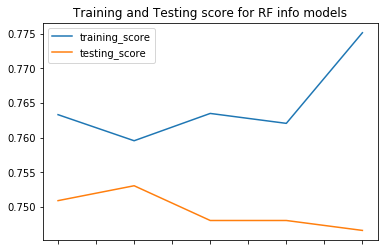

In [111]:
results.loc[['training_score', 'testing_score'], ['RandomForestClassifier_info_1', 'RandomForestClassifier_info_2', 'RandomForestClassifier_info_3', 'RandomForestClassifier_info_4', 'RandomForestClassifier_info_5']].transpose().plot.line()
plt.title('Training and Testing score for RF info models')
plt.show()

A note however, I could see above actually the model was performing better in the training accuracy as I added more variables for each model via polynomial features and removing the amount_invalid feature. It was just that the testing accuracy was reducing, and I could see this was due to overfitting.

I could improve the accuracy and performance of the info model further by using RF info model 5, but adding more data, as I already noted the dataset for the offers_info dataset was half the size of the BOGO and discount datasets. Hence, ultimately with more data and with performance tuning, removing unnecessary variables and feature transformation, with more data I could have ultimately got the performance of the model perhaps above 80%.

#### b. (v). Discussion on best models and feature importances:

I was done with refining the 3 models, I could check the results for our best models for all 3 and check the feature importances to see the top drivers of effectiveness of offers.

In [112]:
# Got best model overall for bogo, discount and info offers

best_model('bogo').append([best_model('discount'), best_model('info')]).transpose()

For bogo RF model:
For discount RF model:
For info RF model:


,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.049047,0.046075,0.018372
testing_score,0.828316,0.874656,0.753042
train_time,0.236652,0.224031,0.084083
training_score,0.846882,0.867570,0.759534


Overall, I could see that the top performing models were the 2nd model (with GridSearch to find optimal model parameters) for predicting effectiveness of  discount offers and informational offers, whereas the best performing model for BOGO was after performing GridSearch to find the optimal parameters and removing amount_invalid column.

In order to find the most influential drivers of an effective offer, we can check the feature importances of our best models above.

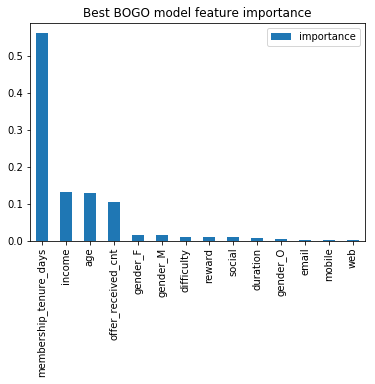

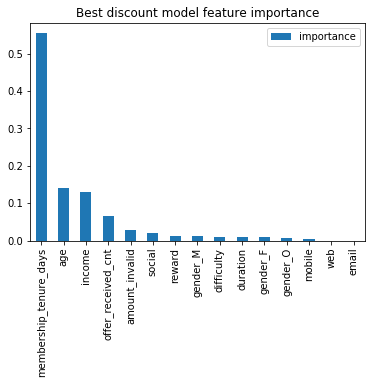

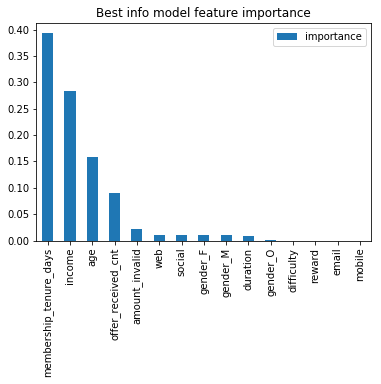

In [113]:
# Showed feature importance
# Bogo_3 model
# Prepared data same as BOGO 3 state

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type', 'amount_invalid']
features, target = data_prep(offers_bogo, drop_cols_prep)

feature_importances = pd.DataFrame(bogo_3.feature_importances_,
                                   index = features.columns,
                                    columns = ['importance']).sort_values('importance', ascending = False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

# Discount_2 model
# Prepared data similar to discount_2 state

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_discount, drop_cols_prep)

feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns = ['importance']).sort_values('importance', ascending = False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

# Info_2 model
# Prepared data similar to info_2 state

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'offer_type']
features, target = data_prep(offers_info, drop_cols_prep)

# Printed feature importance

feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns = ['importance']).sort_values('importance', ascending = False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

Checking on the feature importance to analyse the main drivers of an effective offer, I could see that the most important driver of effective offers across all three were the tenure of membership. However, the 2nd most important feature was different for one of the three models.

For a BOGO offer, the membership tenure was the most important feature, and the other variables were a lot smaller in proportions. Income, age and offer_received_cnt were the 2nd, 3rd and 4th most important features, but their proportions were very small.

For a discount offer, after the membership tenure, age and income were the next most important variables. But it was still very small in proportions.

The feature importances for the informational offer models were more distributed compared to the BOGO and discount models, with income being the 2nd most important feature. Age was the third and offer_recieved_cnt interestingly being the 4th.

#### c. Exploration on users in Groups 3 and 4 - People who purchased regardless of viewing any offers

I had earlier delineated those in groups 3 and 4 as people who would purchase regardless of viewing any offers. Now I could do some exploratory analyses to see what kind of demographic this group of users consist of.

#### c. (i). Data Preparation:

It would be interesting to see how people in groups 3 and 4 contrast with people in groups 1 and 2, so I decided to compare between all 3.

First, I needed to append the data from all groups from the three offer types together, then I compared the characteristics of each group via visualizations.

In [114]:
# Appended datasets together

# Grp 3+4

grp3_4 = grp3_bogo.append(grp3_discount, sort = False)
grp3_4 = grp3_4.append(grp3_info, sort = False)
grp3_4 = grp3_4.append(grp4_bogo, sort = False)
grp3_4 = grp3_4.append(grp4_discount, sort = False)
grp3_4 = grp3_4.append(grp4_info, sort = False)

# Grp1

grp1_all = grp1_bogo.append(grp1_discount, sort = False)
grp1_all = grp1_all.append(grp1_info, sort = False)

# Grp2

grp2_all = grp2_bogo.append(grp2_discount, sort = False)
grp2_all = grp2_all.append(grp2_info, sort = False)

# Got unique person-offer_id pairs

grp3_4 = grp3_4[['person', 'offer_id']].groupby(['person', 'offer_id']).count().reset_index()
grp1_all = grp1_all[['person', 'offer_id']].groupby(['person', 'offer_id']).count().reset_index()
grp2_all = grp2_all[['person', 'offer_id']].groupby(['person', 'offer_id']).count().reset_index()

# Got membership_tenure_days

grp3_4 = member(grp3_4)
grp1_all = member(grp1_all)
grp2_all = member(grp2_all)

# Merged with transcript to check transaction amount

grp3_4 = grp3_4.merge(transcript[['person', 'offer_id', 'amount']].groupby(['person', 'offer_id']).sum(), on = ['person', 'offer_id'], how = 'left')
grp1_all = grp1_all.merge(transcript[['person', 'offer_id', 'amount']].groupby(['person', 'offer_id']).sum(), on = ['person', 'offer_id'], how = 'left')
grp2_all = grp2_all.merge(transcript[['person', 'offer_id', 'amount']].groupby(['person', 'offer_id']).sum(), on = ['person', 'offer_id'], how = 'left')

I also cleaned the dataset of null values, similar to the preparation of the datasets above for modeling.

In [115]:
# Checked null values

print("For grp 3 and 4:")
print((grp3_4.isnull().sum() / len(grp3_4)) * 100)

# Dropped null values

grp3_4 = grp3_4.dropna()

# Checked null values

print("For grp 1:")
print((grp1_all.isnull().sum() / len(grp1_all)) * 100)

# Dropped null values

grp1_all = grp1_all.dropna()

# Checked null values

print("For grp 2:")
print((grp2_all.isnull().sum() / len(grp2_all)) * 100)

# Dropped null values

grp2_all = grp2_all.dropna()

For grp 3 and 4:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    9.019155
income                    9.019155
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 1:
person                    0.000000
offer_id                  0.000000
age                       0.000000
gender                    5.896762
income                    5.896762
membership_tenure_days    0.000000
amount                    0.000000
dtype: float64
For grp 2:
person                     0.000000
offer_id                   0.000000
age                        0.000000
gender                    21.131608
income                    21.131608
membership_tenure_days     0.000000
amount                     0.000000
dtype: float64


In [116]:
# Checked size of groups

print("Size of group 1: " + str(len(grp1_all['person'])))
print("Size of group 3 + 4: " + str(len(grp3_4['person'])))
print("Size of group 2: " + str(len(grp2_all['person'])))

Size of group 1: 26507
Size of group 3 + 4: 18904
Size of group 2: 5729


Comparing the sizes of the 3 groups, I could see that group 1 was the largest, while group 2 was the smallest, which was unsurprising as I had seen that the classes in my datasets were imbalanced in favour of positive classes (i.e. effective_offers = 1). Meanwhile for people in groups 3 and 4 there were quite a significant number of people as well, larger than the number of people in group 2.

#### c. (ii). Exploration of demographic characteristics:

Meanwhile, in order to effectively compare between the groups, I created a function to efficiently visualize the groups together.

In [117]:
# Created function for plotting multiple histograms overlaying the 3 groups

def plot_hist(variable, bins = None):
    plt.hist(grp1_all[variable], alpha = 0.5, label = 'group 1', bins = bins)
    plt.hist(grp3_4[variable], alpha = 0.5, label = 'group 3 and 4', bins = bins)
    plt.hist(grp2_all[variable], alpha = 0.5, label = 'group 2', bins = bins)
    plt.legend(loc = 'upper right')
    plt.title('distribution of ' + variable + ' between group 1, group 2 and groups 3 + 4')
    plt.show()

I could explore the income distribution between the 3 groups.

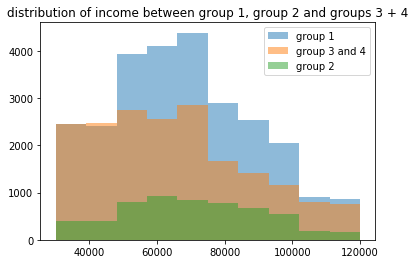

In [118]:
# Plotted distribution of income

plot_hist('income')

Across the 3 segments, most people fall within the middle range of income (50K - 100K). The income distribution between the 3 segments are relatively similar.

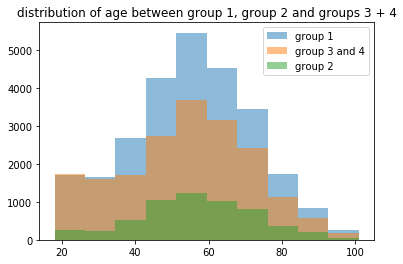

In [119]:
# Plotted ditribution of age

plot_hist('age')

Age distribution looked relatively similar between the 3 groups as well, with most people between the age 40-80 years old.

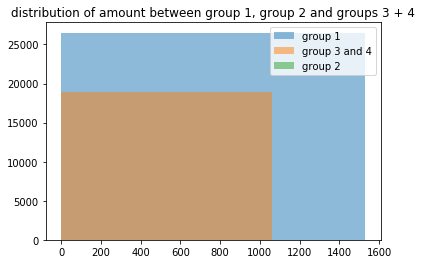

In [120]:
# Plotted distribution of amount spent given an effective offer

plot_hist('amount', bins = 1)

Group 2 were people who did not spend at all as the offers were ineffective on them, hence they were not in the graph. But for groups 1 and 3 + 4, I could see that the amount spent was relatively similar, except that people in group 1 spent slightly more. This was to be expected as I might expect that the offers managed to incentivise them to purchase more, hence their overall spend increased.

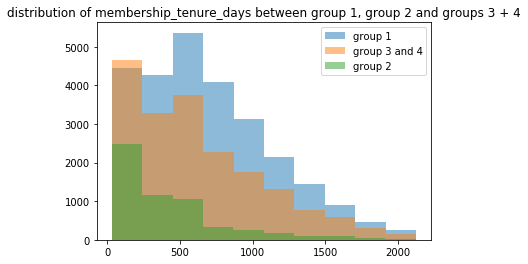

In [121]:
# Plotted tenure of membership

plot_hist('membership_tenure_days')

The distribution of membership tenure also looks similar between the 3 segments, with most people between 0-700 days of tenure. It appeared as though there were not much demographic characteristic differences between the 3 groups, at least in the current data provided.

#### d. Potential all-in-one model

Out of curiosity, I wondered if I could predict the effectiveness of an offer if the offer type was included as a categorical feature. Would the type of offer affect the user's responsiveness?

To do this, I would need to do some minor data preparation to prepare the data for a multiclass model.

In [122]:
# Appended datasets together

offers_bogo['offer_type'] = 'bogo'
offers_info['offer_type'] = 'informational'
offers_discount['offer_type'] = 'discount'
offers = offers_discount.append(offers_bogo, sort = False)
offers = offers.append(offers_info, sort = False)

# Created dummy variable for offer_type categorical variable

offers = dummy(offers, 'offer_type')

In [123]:
# Did grid search to find optimal parameters for RF model

drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'amount_invalid']
features, target = data_prep(offers, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

rand_forest_param_selection(X_train, y_train)

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 2,
 'n_estimators': 50}

In [124]:
drop_cols_prep = ['person', 'offer_id', 'effective_offer', 'amount_invalid']
features,target = data_prep(offers, drop_cols_prep)
X_train, X_test, y_train, y_test = model_pipeline(features, target)

# Initialized the model

all_in_one = RandomForestClassifier(random_state = 5, criterion = 'gini', max_depth = 20, max_features = 'auto', min_samples_split = 2, n_estimators = 50, min_samples_leaf = 15)

results = pd.concat([results[:], run_model(baseline, all_in_one, 'all_in_one')], axis = 1)

DecisionTreeClassifier trained on 25594 samples.
MSE_train: 0.1761
MSE_test: 0.1753
Training accuracy:0.8239
Test accuracy:0.8247
             precision    recall  f1-score   support

          0     0.5269    0.0778    0.1356      1131
          1     0.8326    0.9850    0.9024      5268

avg / total     0.7786    0.8247    0.7669      6399

RandomForestClassifier trained on 25594 samples.
MSE_train: 0.1638
MSE_test: 0.1749
Training accuracy:0.8362
Test accuracy:0.8251
             precision    recall  f1-score   support

          0     0.5316    0.0893    0.1529      1131
          1     0.8341    0.9831    0.9025      5268

avg / total     0.7806    0.8251    0.7700      6399



In [125]:
# Compared best performance of all 3 models with all_in_one model

results[['RandomForestClassifier_bogo_3', 'RandomForestClassifier_discount_3', 'RandomForestClassifier_info_2', 'DecisionTreeClassifier_all_in_one', 'RandomForestClassifier_all_in_one']]

,RandomForestClassifier_bogo_3,RandomForestClassifier_discount_3,RandomForestClassifier_info_2,DecisionTreeClassifier_all_in_one,RandomForestClassifier_all_in_one
pred_time,0.049047,0.048568,0.018372,0.003018,0.220368
testing_score,0.828316,0.873477,0.753042,0.824660,0.825129
train_time,0.236652,0.237819,0.084083,0.056195,1.172886
training_score,0.846882,0.869044,0.759534,0.823904,0.836212


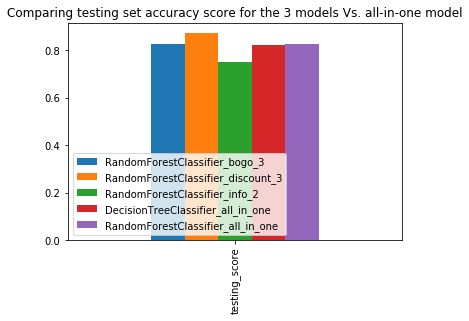

In [126]:
results.loc[['testing_score'], ['RandomForestClassifier_bogo_3', 'RandomForestClassifier_discount_3', 'RandomForestClassifier_info_2', 'DecisionTreeClassifier_all_in_one', 'RandomForestClassifier_all_in_one']].plot.bar()
plt.title('Comparing testing set accuracy score for the 3 models Vs. all-in-one model')
plt.legend(loc = 3)
plt.show()

Comparing the performance of the three best models for each offer type with the all_in_one model, I caould see that having the all-in-one model was not as good as the RF bogo and discount models, and was about slightly better than the info model. This was probably due to the info model pulling down the performance, resulting in lower accuracy for the all in one model. I suspect that if I were to break down the all-in-one model performance to just looking at its ability to predict the effectiveness of informational offer types, it would also be worse than its performance predicting the other two types.

If I take a step back and look at the big picture, it was more useful to have a higher accuracy for three separate models, as opposed to one all-in-one model. This was because the BOGO and discount offers were actually aimed at driving sales with some promotional cost, whereas the informational offer was essentially 'free' with no cost, and if they can drive sales that would be a bonus.

Hence, I would actually suggest that the three separate models were more useful.

#### e. Given an effective offer, could we predict how much someone would spend?

In addition to the all-in-one model, since I already kept the datasets of effective transactions, I was curious to know if I could build a regression model to predict how much someone would spend, given an effective offer. I could have built a model separately for each offer type to predict their spend, but I was curious to know if the type of offer would also determine a user's level of spend.

To do this, I had already assigned effective offers based on group 1 customers. From there, I just needed to sum up their amount of spend driven by offers to see if I could predict how much someone would spend depending on the offer type.

In [127]:
# Appended all three datasets together

grp1 = grp1_bogo.append(grp1_discount, sort = False)
grp1 = grp1.append(grp1_info, sort = False)

# Dropped unnecessary columns

drop_cols('effective_offer', grp1, inplace = True)

# Got offer details

grp1 = grp1.merge(portfolio, how = 'left', on = 'offer_id')

I had only taken into account transactions that were influenced by an offer (i.e. valid_completed = 1) as I wanted to predict the spend given (i.e. based on) the influence of an effective offer.

In [128]:
# Got sum of valid transactions per person based on unique person and offer_id pair

grp1 = grp1.merge(transcript[['person', 'offer_id', 'amount']][transcript['valid_completed'] == 1].groupby(['person', 'offer_id']).sum(), on = ['person', 'offer_id'])

In [129]:
# Got demographic data and membership_tenure details

grp1 = member(grp1)

# Resetted index for offers_info

grp1 = drop_cols('index', grp1.reset_index())

# Reused offers_info channel_col function to expand channel column into categorical variables

channel_col('web', grp1)
channel_col('email', grp1)
channel_col('mobile', grp1)
channel_col('social', grp1);

drop_cols('channels', grp1, inplace = True);

# Reused offers_info function to prep dataset

grp1 = prep_offers_df(grp1)

# Encoded offer type as dummy variables

grp1 = dummy(grp1, 'offer_type')

Since this was a regression model, I needed to prevent multicollinearity by reducing the level of the dummy variables by 1, dropping those columns.

In [130]:
# Added one level of dummy variable to drop

drop_cols_prep = ['person', 'offer_id', 'amount', 'social', 'gender_O', 'offer_type_informational']
target = grp1['amount']
features = drop_cols(drop_cols_prep, grp1)

Since this was a regression model, I needed to change the metrics such that it was not a classification model. Hence, I tweaked my train_predict and run_model functions.

In [131]:
# Tweaked train_predict function -

def train_predict_reg(learner, X_train, y_train, X_test, y_test): 
    '''
    inputs:
    
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    
    '''
    results = {}
    
    # Fitted the learner to the training data and get training time
    
    start = time() 
    learner = learner.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Got predictions on the test set(X_test), then got predictions on first 300 training samples
    
    start = time() 
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() 
    
    # Calculated the total prediction time
    
    results['pred_time'] = end - start
    
    # Added training accuracy to results
    
    results['training_score'] = learner.score(X_train, y_train)
    
    # Added testing accuracy to results
    
    results['testing_score'] = learner.score(X_test, y_test)
    
    print("{} trained on {} samples.".format(learner.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train, predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test, predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    return results

In [132]:
def run_model_reg(clf1, clf2, name):
    
    '''
    input:
    
    - clf1: baseline regression model
    - clf2: 2nd regression model to compare
    - name: name to keep track of comparison
    
    output:
    
    - dataframe containing results of training and prediction of model
    
    '''
    
    # Collected results on the learners
    
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' + name
        results[clf_name] = {}
        results[clf_name] = train_predict_reg(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

In [133]:
X_train, X_test, y_train, y_test = model_pipeline_poly(features, target, 2)

# Initialized the model

clf1 = Ridge(alpha = 2, random_state = 2)
clf2 = DecisionTreeRegressor(random_state = 2)

results_reg = run_model_reg(clf1, clf2, 'reg')

Ridge trained on 21011 samples.
MSE_train: 5149.4918
MSE_test: 5264.4857
Training accuracy:0.0901
Test accuracy:0.0863
DecisionTreeRegressor trained on 21011 samples.
MSE_train: 0.0410
MSE_test: 11106.1821
Training accuracy:1.0000
Test accuracy:-0.9277


In [134]:
results_reg

,Ridge_reg,DecisionTreeRegressor_reg
pred_time,0.005617,0.017274
testing_score,0.086260,-0.927664
train_time,0.055026,1.533889
training_score,0.090122,0.999993


The regression models really underperformed in terms of predicting the amount spent. It appeared with the current data within our group 1 of customers, there was not enough information to predict the amount that could be driven by the offer type. I could see the Decision Tree Regressor model really overfit the data, with a very high training score but sub par testing score. Meanwhile, the linear regression model (with ridge/l2 regularization) also showed a minimal correlation between the features and the target variable. The model really underfitted the data.

I may get better performance if I breaked the models up into 3 different models based on offer type again; or even tried to include non-influenced/invalid transactions, but this could be an exploration for another time.

### Conclusion:

Overall, I found this project challenging, mainly due to the structure of the data in the transcript dataset. I had started out with 2 business questions:

- What are the main drivers of an effective offer on the Starbucks app?
- Could the data provided, namely offer characteristics and user demographics, predict whether a user would take up an offer?

#### a. Reflection:

#### a. (i). Question 1 findings:

For Question 1, the feature importance given by all three models were that the tenure of a member was the biggest predictor of the effectiveness of an offer. Further study would be able to indicate what average tenure days would result in an effective BOGO offer.

For all three models, the top three variables were the same - membership tenure, income and age. However, income and age switched orders depending on offer type.

For BOGO and discount offers, the distribution of feature importances were relatively equal. However, for informational offers, the distribution is slightly more balanced, with income the second most important variable.

#### a. (ii). Question 2 findings:

My decision to use three separate models to predict the effectiveness of each offer type ended up with good accuracy for the BOGO and discount models (82.83% for BOGO and 87.35% for discount), while slightly less accurate performance for informational offers (75.3%). However, I would regard 75% as acceptable in a business setting, as for informational offers, there was no cost involved to inform users of a product.

Meanwhile, for BOGO and discount models, I am quite happy with the 80% and above accuracy, as in a business setting that would be acceptable to show offers to people, even if the model misclassifies a few, the overall revenue increase might justify the few mistakes.

#### b. Main challenges and potential improvement:

When analysing and building the machine learning models to answer the above questions, reflections on my main challenges and findings were as follows:

#### b. (i). Attribution framework for assigning offer_ids for transactions:

In order to answer Question 1, I had to first define what an 'effective offer' means using the transactional records. This proved to be the trickiest portion of the project. I had to define a funnel for what an effective conversion would look like, as I had data on both effective and noneffective conversions. Thus, I was desigining an attribution model for the conversion events (offer completed and transaction events) based on the events that occurred prior for each person.

I ended up having to separate the users into four different pools, based on their actions in the transcript data:

- Group 1: People who were influenced by offers and thus purchased/completed the offer(successful/effective conversion of offer)
- Group 2: People who received an offer but were not influenced and thus no conversion event (ineffective conversion of offer)
- Group 3: People who had conversion events but were not actually influenced by an offer
- Group 4: People who received offers but no views or action taken

Even after separating the groups, it was challenging to assign the people in group 3 based on the transactional data. I had to define the event space where the right sequence of events would occur before I could assign an offer id to transactions (which did not have an offer_id), essentally designing a event/sequence-based attribution window.

After attributing the conversions to specific offers, the rest of the data preparation and cleaning was relatively straightforward. I was grateful that there were not many missing values, and the preparation of categorical variables was also relatively straightforward.

#### b. (ii). Feature engineering:

I decided to do some basic feature engineering as I found the model had slightly underfit. It improved the performance of the model slightly, and the membership_tenure feature I had engineered out of the became_member_on column ended up being the most important predictor variable.

However, overall I found that I could not think of additional features using the time data, even though I had the hunch that the time of receiving the offer might be quite influential in determining whether it was effective or not.

#### b. (iii). Model implementation decisions:

I had made the decision to build three separate models depending on offer types based on my definition of the problem statement - as I wanted to discover what would drive an effective offer, I thought it made more sense to remove noise from the data by separating the data into the offer types. My decision ended up to be quite a good one as the single BOGO and discount models got good performance in testing scores, compared to the all-in-one model overall score.

For the info model, the accuracy was slightly worse as I had less records overall (half of the BOGO and discount models). As elaborated above, I believed that if I had more data, I could have gotten the accuracy higher, as there was a clear diverging pattern occurring between the training and testing score as I made decisions to improve the model fit like adding polynomial features and removing 'noisy' features like the amount_invalid feature. Due to the limited data, my decisions ended up with the model overfitting, hence I believed the model accuracy would have benefitted from more data.

An additional note on model selection - I selected tree-based models as I wanted to assess feature importance, but I could have extended this study further by testing a parametric/ regression model (e.g. logistic regression for classification tasks). The weights of the coefficients from a regression model might have been interesting to contrast with the feature importance of a tree-based model, given that both models have different ways of analysing the data. The feature membership_tenure_days might not have been the highest weighted feature, in contrast to how it was in this study.

#### b. (iv). Explored demographics of different customer groups:

I was curious to know what the characteristics were of groups 3 and 4, which are customers who are not influenced by an offer at all. However, after comparing their characteristics with groups 1 and 2, I could not see any significant differences in their demographics.

I would have liked to have more data to perhaps understand why this group of customers tend to not be influenced by offer, in order to make useful suggestions on how to give a good customer experience to these customers, even if we do not serve them any offers.

#### b. (v). Model accuracy in predicting amount spent given an effective offer:

The regression model I built out of curiosity to see if I could predict the amount a user would spend, given that they were effectively influenced by an offer. The motivation was that if I could predict how much someone would spend given an offer, perhaps I could assess which offers bring in the most revenue.

However, my model found virtually no correlation between the features provided (namely, offer characteristics and demographics of app users) with the amount spent per user. These features were not strong enough to predict the amount spent per user. Perhaps if I also had a value of the offer, for example, for a discount offer, the value of the discount in dollar terms, perhaps I might be able to predict better.

Perhaps I could have broken them up into three different models for the three offer types, the way I did with the binary classification models, in order to get a better result. However, given that this was just a curiosity and I wanted to explore if the offer type would be a statistically significant predictor feature, I built an all-in-one model for this instance. This would be worth exploring further, given more time and data.